In [1]:
import pandas as pd
import numpy as np
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import plotly
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio

# Sci-kit Learn
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.decomposition import NMF, LatentDirichletAllocation, PCA
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, DBSCAN
#PyLDAvis
import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()
#CorEx
from corextopic import corextopic as ct
from corextopic import vis_topic as vt

In [2]:
# ignore warnings
warnings.filterwarnings("ignore") 

In [3]:
# import the data
df = pd.read_csv('dataSentiment.csv')

In [4]:
df.head(1)

,vidId,videoText,date,title,views,likes,dislikes,commentCount,vidLength,description,channel,country,totChanViews,totSubscribers,totChanVideos,music,textCleaned,text_polarity,text_subjectivity,count
0,7PIMiDcwNvc,[Music] I am most of all happy and grateful t...,2019-08-24,Marzia & Felix - Wedding 19.08.2019,39403934.0,5509252.0,33359.0,526815.0,00:06:22,"Our footage from the wedding, best day of my l...",PewDiePie,US,2.798403e+10,110000000.0,4443.0,1,happy grateful finally mighty hospital met tim...,0.531169,0.703896,58


Assign text to a vairable names 'corpus'

In [5]:
corpus = df['textCleaned'].fillna(value='')

In [6]:
corpus.head()

0    happy grateful finally mighty hospital met tim...
1    lilly old think time talk mom 32 year old chir...
2    yum favorite god sweet ew god teeth covered mo...
3    guy welcome youtube channel guy know just left...
4    bunny check parent gotten stupid virus phone s...
Name: textCleaned, dtype: object

#### Functions

In [7]:
def top_text(text_matrix_df, topic, n_text):
    '''
    This function returns the top texts per topic
    '''
    return (text_matrix_df
            .sort_values(by=topic, ascending=False)
            .head(n_text)[['vidId', 'title', 'channel']]
            .values) 

def top_words(word_matrix_df, topic, n_words):
    '''
    This function returns the top words per topic
    '''
    return (word_matrix_df
            .sort_values(by=topic, ascending=False)
            .head(n_words))[topic]

### Stop Words

This is a list of stop words that I needed to add in order to create clearer separation amongst my topics

In [8]:
stop_words = ['friend', 'new', 'told', 'sorry', 'person', 'help', 'home', 'great', 'long', 'went', 'would', 'best', 'use', \
             'try', 'cool', 'different', 'nice', 'fun', 'add', 'maybe', 'eye', 'line', 'like', 'feel', 'using', 'super', 'literally', \
             'water', 'used', 'just', 'going', 'used','house', 'place', 'end', 'dude', 'head', 'minute', 'number', '10', 'get', 'left', \
             'stop', 'hand', 'coming', 'boy', 'star', 'hit', 'man', 'buy', 'point', 'guess', 'started', 'finally', 'making', 'ya', 'ha', 'ok', \
             'definitely', 'turn', 'far', 'light', 'wanted', 'decided', 'one', 'bit', 'food', 'wow', 'half', 'face', 'item', 'sure', \
             'inside', 'favorite', 'bring', 'night', 'came', 'week', 'girl', 'kid', 'having', 'week', 'bed', 'watch', 'crazy', 'middle', \
             'feeling', 'hope', 'weird', 'open', 'red', 'green', 'edge', 'yellow', 'let', 'whoa', 'dog', 'look', 'got', 'huh', 'bag', \
             'excited', 'cute', 'family', 'cold', 'mask', 'woman', 'mom', 'ice', 'key', 'soon', 'apple', 'hard', 'card', 'test', 'subscribe', \
             'sick', 'team', 'hi', 'talk', 'dad', 'happy', 'live', 'word', 'talking', 'character', 'believe', 'hello', 'question', 'picture', \
              'idea', 'parent', 'saying', 'fine', 'story', 'wrong', 'leave', 'sound', 'amazing', 'welcome', 'old', 'seem', 'awesome', 'hear', \
             'would', 'hour', 'tree', 'case', 'piece', 'hold', 'small', 'quite', 'click', 'usually', 'small', 'extra', 'pop', 'easy', 'thanks', \
             'jobs', 'ooh', 'stay', 'phone', 'change', 'room', 'playing', 'wearing', 'black', 'channel', 'fit', 'basically', 'set', 'wall', \
             'building', 'type', 'bunch', 'ahead', 'cut', 'record', 'give', 'play', 'blue', 'able', 'reason', 'important', 'hot', 'seven', \
             'camera', 'happened', 'god', 'know', 'button', 'happen', 'body', 'cuz', 'son', 'bro']

In [9]:
# stop_words = ['told', 'sorry', 'person', 'great', 'long', 'went', 'would', 'best', 'use', \
#               'try', 'cool', 'different', 'nice', 'fun', 'add', 'maybe', 'line', 'like', 'feel', 'using', 'super', 'literally', \
#               'used', 'just', 'going', 'used', 'place', 'end', 'dude', 'head', 'minute', 'number', '10', 'get', 'left', \
#               'stop', 'hand', 'coming', 'hit', 'man', 'buy', 'point', 'guess', 'started', 'finally', 'making', 'ya', 'ha', 'ok', \
#               'definitely', 'turn', 'far', 'light', 'wanted', 'decided', 'one', 'bit', 'food', 'wow', 'half', 'face', 'item', 'sure', \
#               'inside', 'favorite', 'bring', 'night', 'came', 'week', 'girl', 'kid', 'having', 'watch', 'crazy', 'middle', \
#               'feeling', 'hope', 'weird', 'open', 'red', 'green', 'edge', 'yellow', 'let', 'whoa', 'look', 'got', 'huh', 'bag', \
#               'excited', 'cute', 'family', 'cold', 'mask', 'woman', 'mom', 'ice', 'key', 'soon', 'apple', 'hard', 'card', 'test', 'subscribe', \
#               'team', 'hi', 'talk', 'dad', 'happy', 'live', 'word', 'talking', 'character', 'believe', 'hello', 'question', 'picture', \
#               'idea', 'parent', 'saying', 'fine', 'story', 'wrong', 'leave', 'sound', 'amazing', 'welcome', 'old', 'seem', 'awesome', 'hear', \
#               'would', 'hour', 'tree', 'case', 'piece', 'hold', 'small', 'quite', 'click', 'usually', 'small', 'extra', 'pop', 'easy', 'thanks', \
#               'jobs', 'ooh', 'stay', 'change', 'playing', 'wearing', 'channel', 'fit', 'basically', 'set', \
#               'building', 'type', 'bunch', 'ahead', 'cut', 'record', 'give', 'play', 'able', 'reason', 'important', 'hot', 'seven', \
#               'camera', 'happened', 'god', 'know', 'button', 'happen', 'cuz', 'son']

# LDA
#### Count Vectorizer
LDA performs well with whole interger inputs, therefore I used Count Vectorizer to transform the text into a vector.

In [10]:
# vectorize documnets using countVectorizer for LDA
countVect = CountVectorizer(ngram_range=(1,2),
                            stop_words=stop_words,
                            max_df=0.4, 
                            min_df=10,
                            max_features=1000)

count_word_matrix = countVect.fit_transform(corpus)

count_vocab = countVect.get_feature_names_out()

In [11]:
count_word_matrix.shape

(1094, 1000)

In [12]:
# assign a n_components val
lda_n_compnents = 15
# assign LDA
lda = LatentDirichletAllocation(n_components=lda_n_compnents, learning_method='batch', random_state=0) # assign batch for quicker calculation
lda.fit(count_word_matrix)

LatentDirichletAllocation(n_components=15, random_state=0)

In [13]:
# create the text topic matrix from the word matrix
lda_text_topic_matrix = lda.transform(count_word_matrix)

In [14]:
# create a dataframe of the text topic matrix
lda_text_topic_matrix_df = pd.DataFrame(lda_text_topic_matrix).add_prefix('topic_')
# add additional columns from the original dataframe to identify rows
lda_text_topic_matrix_df[['vidId', 'title', 'channel', 'textCleaned']] = df[['vidId', 'title', 'channel', 'textCleaned']]
lda_text_topic_matrix_df.head(1)

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13,topic_14,vidId,title,channel,textCleaned
0,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922,0.695231,0.003922,0.253789,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922,7PIMiDcwNvc,Marzia & Felix - Wedding 19.08.2019,PewDiePie,happy grateful finally mighty hospital met tim...


In [15]:
# create a dataframe of the word topic matrix
lda_word_topic_matrix_df = pd.DataFrame(lda.components_, columns=count_vocab).T.add_prefix('topic_')
lda_word_topic_matrix_df.head()

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13,topic_14
000,0.066667,37.770929,1.209310,0.066667,0.066667,188.471328,36.890305,0.066667,0.066667,8.826193,27.231933,0.066667,0.066667,0.066667,0.066667
100,17.269401,45.403518,0.067944,23.678912,2.585162,129.437088,35.397722,14.949675,14.780001,17.886226,73.194673,0.066667,1.593035,5.567718,0.122259
11,8.334871,19.675677,0.066668,29.100934,14.263628,11.226329,1.445797,0.066667,40.552632,10.028046,7.041963,5.790959,1.493362,0.067237,26.845230
12,27.507997,8.144291,9.094304,27.572369,6.902799,25.943575,6.705700,4.067187,40.389857,15.099694,15.860981,0.066667,2.065518,4.700221,3.878842
13,0.066667,8.587610,0.066667,12.586574,0.066667,18.396035,21.562060,0.066667,9.507944,2.086571,13.264232,16.253443,3.394636,0.066667,1.027562


In [16]:
# # check the top words in each topic for the LDA model
# for num in range(0,lda_n_compnents):
#     topic = f'topic_{num}'
#     print(num)
#     print(top_words(lda_word_topic_matrix_df, topic, 10))
#     print()
#     print("...................................")

In [17]:
# # check the top text in each topic for the LDA model
# for num in range(0,lda_n_compnents):
#     topic = f'topic_{num}'
#     print(num)
#     for text in top_text(lda_text_topic_matrix_df, topic, 5):
#         print(text)
#         print()
#     print("...................................")

##### Test pyLDAvis

In [18]:
# pyLDAvis.sklearn.prepare(lda, count_word_matrix, countVect)

In [19]:
# pyLDAvis.sklearn.prepare(lda, count_word_matrix, countVect, mds='mmds')

In [20]:
# pyLDAvis.sklearn.prepare(lda, count_word_matrix, countVect, mds='tsne')

I was pretty dissapointed with the topics created by the LDA model. For some reason there was a lot of crossover in content. So I made the decision to try 'Non-Negative Matrix Factorization,' or NMF.

There were positivies of using the LDA model: I was able to use pyLDAvis to discover and add words to a stop_words list that helped to better differentiate topics, which I will use in the NMF model. 

# NMF

#### TFIDF Vectorizer

For NMF I chose to use the TfidfVectorizer to transform the text into a vector becuase it focuses on the frequency of words and gives each word a weighting, which helps to identify word importance.

In [21]:
# vectorize documents using TfidfVectorizer for NMF
tfidf = TfidfVectorizer(ngram_range=(1,2),
                        stop_words=stop_words,
                        max_df=.4, 
                        min_df=10, 
                        max_features=1000)

tfidf_word_matrix = tfidf.fit_transform(corpus)

tfidf_vocab = tfidf.get_feature_names_out()

In [22]:
tfidf_word_matrix.shape

(1094, 1000)

In [23]:
# assign a n_components val
nmf_n_compnents = 15
# assign NMF
nmf = NMF(n_components=nmf_n_compnents, random_state=10, max_iter=2000)

nmf.fit(tfidf_word_matrix)

NMF(max_iter=2000, n_components=15, random_state=10)

In [24]:
# create the text topic matrix from the word matrix
tfidf_text_topic_matrix = nmf.transform(tfidf_word_matrix)

In [25]:
# create the text topic matrix from the word matrix
tfidf_text_topic_matrix_df = pd.DataFrame(tfidf_text_topic_matrix).add_prefix('topic_')
# add additional columns from the original dataframe to identify rows
tfidf_text_topic_matrix_df[['vidId', 'title', 'channel', 'textCleaned']] = df[['vidId', 'title', 'channel', 'textCleaned']]
tfidf_text_topic_matrix_df.head(1)

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13,topic_14,vidId,title,channel,textCleaned
0,0.0,0.0,0.0,0.0,0.003604,0.0,0.0,0.0,0.003047,0.005972,0.000838,0.0,0.0,0.070513,0.007854,7PIMiDcwNvc,Marzia & Felix - Wedding 19.08.2019,PewDiePie,happy grateful finally mighty hospital met tim...


In [26]:
tfidf_word_topic_matrix_df = pd.DataFrame(nmf.components_, columns=tfidf_vocab).T.add_prefix('topic_')
tfidf_word_topic_matrix_df.head()

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13,topic_14
000,0.016658,0.006080,0.223855,0.010693,0.030050,0.000000,0.000000,0.000000,0.000000,0.000000,0.006231,0.000000,0.051755,0.035780,0.000000
100,0.011417,0.000000,0.148078,0.002085,0.046207,0.004058,0.018620,0.000000,0.005883,0.004237,0.041920,0.007082,0.063796,0.067046,0.000000
11,0.020019,0.001414,0.023962,0.011491,0.000000,0.086535,0.007277,0.010669,0.000000,0.000000,0.013401,0.003889,0.017849,0.072084,0.005981
12,0.034491,0.010573,0.023082,0.005321,0.007892,0.010261,0.014232,0.020149,0.006009,0.027988,0.003643,0.000000,0.021880,0.081539,0.009520
13,0.003739,0.000000,0.043131,0.000000,0.015186,0.023800,0.009421,0.000000,0.007298,0.003346,0.000000,0.000000,0.007767,0.049184,0.000000


### Topic Interpretation

In [27]:
# check the top words in each topic for the NMF model
for num in range(0,nmf_n_compnents):
    topic = f'topic_{num}'
    print(num)
    print(top_words(tfidf_word_topic_matrix_df, topic, 20))
    print()
    print("...................................")

0
car             1.484162
karen           0.905223
somebody        0.485217
door            0.383297
boyfriend       0.349605
money           0.310344
child           0.303885
drive           0.276647
mother          0.261653
took            0.254225
grandma         0.245801
madam           0.244721
police          0.241988
road            0.240811
window          0.239180
tick            0.234508
guy enjoyed     0.233369
wolf            0.229422
watching bye    0.220247
walk            0.218660
Name: topic_0, dtype: float64

...................................
1
hair        2.307074
brush       0.185353
dry         0.172887
wash        0.166622
wet         0.134328
section     0.120083
shower      0.117844
towel       0.113420
layer       0.105773
pull        0.099849
glue        0.098042
purple      0.089632
spray       0.087179
straight    0.086511
stuck       0.085401
bye         0.078617
sit         0.078246
texture     0.070795
clip        0.070676
forget      0.066967
Name: top

In [28]:
# check the top text in each topic for the NMF model
for num in range(0,nmf_n_compnents):
    topic = f'topic_{num}'
    print(num)
    for text in top_text(tfidf_text_topic_matrix_df, topic, 5):
        print(text)
        print()
    print("...................................")

0
['jlXXHxWxg08' 'Karens Who Went Too Far' 'SSSniperWolf']

['RbRZlrqoxsw' 'Karens Who Got Caught On Camera' 'SSSniperWolf']

['8zNOd46cVeg' "Karens Who Didn't Know When To Quit" 'SSSniperWolf']

['VCxNOReFNQ0' 'SPOILED GIRL Gets a LAMBO for her Birthday...'
 'SSSniperWolf']

['pkc_d-hyHvs' 'Karens Who Got Caught On Camera' 'SSSniperWolf']

...................................
1
['jzr9tsm1plY' 'Why Our Hair Is Black Girl Magic' 'McClure Twins']

['Gw7wDM3kDC8'
 'Our Family of 9 Hair Wash Day Using the Same Products (Part 1/3)'
 'MAZELEE']

['GRNnLrW64VU'
 'Our Family’s Hair Wash Day Routine 💆🏾\u200d♀️  7 Kids 7 Different Hair Types (Part 1)'
 'MAZELEE']

['J8hyGUA-iKY' 'Trying HAIR LIFE HACKS to see if they Work' 'Little Lia']

['S9kdxvASLxw' 'Tangled Curly Hair Wash Routine | Tips for Detangling!'
 'RAVEN ELYSE']

...................................
2
['fMfipiV_17o' 'Would You Sit In Snakes For $10,000?' 'MrBeast']

['s1ax8Tx_Jz0' 'Would YOU Rather Have A Lamborghini or This House?'
 '

#### Assign column names to their topic using general domain knowledge of video topic groupings

In [29]:
nmf_named_df = pd.DataFrame(tfidf_text_topic_matrix.round(5), \
                            columns = ["videoReviews", "hair", 'prizes', 'food', \
                                      'minecraft', 'games', 'school', 'educational', 
                                      'pregnancy', 'dance_music', 'halloween', \
                                      'clothes', 'challenges', 'beautyCare', \
                                      'christmas'])

nmf_named_df[['vidId', 'title', 'channel', 'textCleaned']] = df[['vidId', 'title', 'channel', 'textCleaned']]

In [30]:
nmf_named_df.shape

(1094, 19)

In [31]:
nmf_named_df.sample(5)

,videoReviews,hair,prizes,food,minecraft,games,school,educational,pregnancy,dance_music,halloween,clothes,challenges,beautyCare,christmas,vidId,title,channel,textCleaned
925,0.00000,0.00000,0.0000,0.02564,0.000,0.00000,0.0000,0.00000,0.01000,0.00000,0.00000,0.01681,0.00000,0.09187,0.00000,9iMGFqMmUFs,What would happen if you didn’t drink water? -...,TED-Ed,water virtually soil moisture ice cap cell ins...
1085,0.00000,0.00000,0.0123,0.00000,0.000,0.03714,0.0000,0.00000,0.00000,0.04405,0.00156,0.00000,0.09343,0.00000,0.00000,7J6kCP9u8zA,Atalanta vs. Man. United: Extended Highlights ...,CBS Sports Golazo,mctominay hfoot ilicicthat really wide s wanbi...
111,0.13556,0.03513,0.0000,0.01388,0.003,0.00350,0.0252,0.00380,0.05249,0.00190,0.05178,0.00000,0.00000,0.02689,0.01252,g_1EnKnzk9g,Tik Toks With A Crazy Plot Twist,SSSniperWolf,hello friend today going checking tick tocks p...
968,0.00000,0.39568,0.0000,0.00000,0.000,0.00000,0.0000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,Gw7wDM3kDC8,Our Family of 9 Hair Wash Day Using the Same P...,MAZELEE,guy today going washing hair going washing hai...
504,0.01157,0.02407,0.0000,0.24762,0.000,0.00000,0.0000,0.00006,0.00000,0.00000,0.00000,0.07856,0.00994,0.00000,0.00000,GyilgS-yD_k,TRICKS Advertisers use to make Food look delic...,SSSniperWolf,hello friend thing mom love thought trust food...


In [32]:
nmf_named_df.to_csv('topicData.csv', index=False)

#### Create a list and dictionary of each topics label

In [33]:
topic_list = ['videoReviews', 'hair', 'prizes', 'food', \
              'minecraft', 'games', 'school', 'educational', 
              'pregnancy', 'dance_music', 'halloween', \
              'clothes', 'challenges', 'beautyCare', \
              'christmas']

topic_dict = {
    0 : "videoReviews",
    1 : "hair",
    2 : "prizes",
    3 : "food",
    4 : "minecraft",
    5 : "games",
    6 : "school",
    7 : "educational",
    8 : "pregnancy",
    9 : "dance_music",
    10: "halloween",
    11: "clothes",
    12: "challenges",
    13: "beautyCare",
    14: "christmas"
}

# CorEx

Made an attempt to use CorEx to get even cleaner topics, but did not see better performance than the NMF modeL

In [34]:
corCountVect = CountVectorizer(ngram_range=(1,2),
                            stop_words=stop_words, 
                            max_df=0.4, 
                            min_df=10,
                            max_features=1000,
                            binary=True)

corCount_word_matrix = corCountVect.fit_transform(corpus)
cor_vocab = list(np.asarray(corCountVect.get_feature_names()))

In [35]:
# n_hidden is the number of topics
# words is your list of words used in your corpus
# it is recommended to add docs=df.data to make it easier to check which sentences are in each resulting topic
cor_model = ct.Corex(n_hidden=15, words=cor_vocab, seed=1)
cor_model.fit(corCount_word_matrix, words=cor_vocab, docs=corpus)

In [36]:
# Print all topics from the CorEx topic model
topics = cor_model.get_topics()
for n,topic in enumerate(topics):
    topic_words,_,_ = zip(*topic)
    print('{}: '.format(n) + ','.join(topic_words))

0: enjoyed video,watching bye,love guy,today guy,guy enjoyed,bye guy,anyways today,make notification,enjoyed,guy watching
1: win,minecraft,kill,game,beat,challenge,build,die,won,winning
2: course,later,heard,couple,morning,sitting,obviously,past,did want,tomorrow
3: thinking,ask,telling,stupid,seen,care,understand,supposed,child,looked
4: entire,imagine,took,mind,absolutely,single,level,worst,apparently,stand
5: finish,sense,possible,turned,final,make sense,starting,sort,art,completely
6: thousand,thousand dollar,30,50,world,20,million,40,worth,spend
7: chance,running,run,close,break,happening,moment,luck,shot,safe
8: working,putting,box,size,actual,outside,hopefully,area,ton,space
9: dollar,money,pick,go,throw,happens,gave,free,giving,job
10: color,wear,white,hair,chicken,comment,chocolate,smell,wash,pink
11: school,ago,high,month,high school,year ago,class,reading,learn,issue
12: really good,perfect,goodness,honestly,actually really,scared,grab,pretty good,funny,stick
13: quick,door,

In [37]:
# Note, instead of using .predict(doc_word), you can also call topic_model.labels
predictions = pd.DataFrame(cor_model.predict(corCount_word_matrix), columns=['topic'+str(i) for i in range(15)])
predictions.head()

,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,topic10,topic11,topic12,topic13,topic14
0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,False,False,True,False,False,False,False,False,False,True,False,True,False,False,False
2,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,False,False,True,False,True,True,False,True,True,True,True,True,True,True,True
4,True,False,True,True,True,False,False,False,False,True,True,False,False,True,True


The makers of CorEx have a created a cool plotting function to see what the TC of each topic is. 
  * Look for an elbow (either at 1 topic or 4 topics) and you can create a cut-off there

In [38]:
plt.figure(figsize=(10,5))
plt.bar(range(cor_model.tcs.shape[0]), cor_model.tcs, color='#4e79a7', width=0.5)
plt.xlabel('Topic', fontsize=16)
plt.ylabel('Total Correlation (nats)', fontsize=16)
plt.show()

In [39]:
topic_model = ct.Corex(n_hidden=15, words=cor_vocab,
                       max_iter=200, verbose=False, seed=1)

topic_model.fit(corCount_word_matrix, words=cor_vocab, docs=corpus, 
                anchors=[['karen'], 
                         ['hair'], 
                         ['prize'], 
                         ['food'],
                         ['minecraft'], 
                         ['squid', 'game', 'football'],
                         ['school'], 
                         ['science'], 
                         ['pregnancy'], 
                         ['dance', 'music'],
                         ['halloween'], 
                         ['clothes'],
                         ['challenge'], 
                         ['makeup', 'bag'],
                         ['christmas']], anchor_strength=10)

# Print all topics from the CorEx topic model
topics = topic_model.get_topics()
for n,topic in enumerate(topics):
    topic_words,_,_ = zip(*topic)
    print('{}: '.format(n) + ','.join(topic_words))

0: hair,wash,brush,lip,shower,mirror,teeth,nose,mama
1: minecraft,block,iron,diamond,chest,wood,damage,stone,dying,craft
2: game,player,played
3: school,high school,class,teacher,grade,student,math,college,birthday,study
4: music,dance,song
5: halloween,candy,orange
6: clothes,outfit,dress,shirt,shopping,dressed,pant,tie,yay
7: challenge,winner,artist
8: makeup,watching bye,bye guy,anyways today,enjoyed video,today guy,guy enjoyed,love guy,make notification,wolf pack
9: christmas,toy
10: later,heard,thinking,gave,ask,course,ago,understand,care,couple
11: world,sense,absolutely,make sense,possible,imagine,turned,moment,plan,apparently
12: pick,entire,seen,eat,throw,perfect,supposed,outside,door,saw
13: working,color,took,go,looked,beautiful,white,really good,putting,rest
14: win,thousand,kill,die,chance,beat,close,build,50,thousand dollar


# Clustering
    *using the NMF model*

#### t-SNE Visualization 

In [40]:
# create a threshold 
threshold = 0    # can do .02 or something similar

idx = np.amax(tfidf_text_topic_matrix, axis=1) > threshold
topics_matrix_filtered = tfidf_text_topic_matrix[idx]

In [41]:
topics_matrix_filtered.shape

(1094, 15)

In [42]:
# must Standard Scale the data before you fit_transform to perform ANY clustering!!
topics_matrix_std = StandardScaler().fit_transform(topics_matrix_filtered)

In [43]:
tsne = TSNE(n_components=2, verbose=1, random_state=0, angle=.1, init='pca')
topics_mapped_2d = tsne.fit_transform(topics_matrix_std)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1094 samples in 0.017s...
[t-SNE] Computed neighbors for 1094 samples in 0.079s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1094
[t-SNE] Computed conditional probabilities for sample 1094 / 1094
[t-SNE] Mean sigma: 0.823591
[t-SNE] KL divergence after 250 iterations with early exaggeration: 66.608582
[t-SNE] KL divergence after 1000 iterations: 0.788985


In [44]:
# FILTERED topic with highest NMF value for each post
max_topic_per_post_list = []
for i in range(topics_matrix_filtered.shape[0]):
    max_topic_per_post_list.append(topics_matrix_filtered[i].argmax())

In [45]:
max_topic_per_post = [[x] for x in max_topic_per_post_list]
tsne_data = np.concatenate((topics_mapped_2d, max_topic_per_post), 1)

In [46]:
def cluster_plot(tsne_data, topic_labels):
    '''
    Plot the t-SNE cluster
    '''
    color_map = {0:  '#e6194b', 1:  '#3cb44b', 2:  '#ffe119', 3:  '#0082c8', 4:  '#f58231', 5:  '#911eb4',
                 6:  '#46f0f0', 7:  '#f032e6', 8:  '#d2f53c', 9:  '#fabebe', 10:  '#008080', 11:  '#e6beff',
                 12:  '#aa6e28', 13:  '#800000', 14:  '#aaffc3'}

    labels = list(range(nmf_n_compnents))

    plt.figure(figsize=(12, 8))
    for topic in range(nmf_n_compnents):
        inds = np.where(tsne_data[:, 2] == topic)[0]
        plt.scatter(x=tsne_data[inds, 0],
                    y=tsne_data[inds, 1],
                    marker='o',
                    s=10,
                    color=color_map[topic],
                    label=topic)

    plt.xlabel('Dimension 1', fontsize=12)
    plt.ylabel('Dimension 2', fontsize=12)
    plt.title('t-SNE Results: Topics in 2-D Space', fontsize=14)
    plt.legend(loc="lower left", labels=topic_labels, fontsize=12, prop={'size': 10}, markerscale=2)
    plt.show()

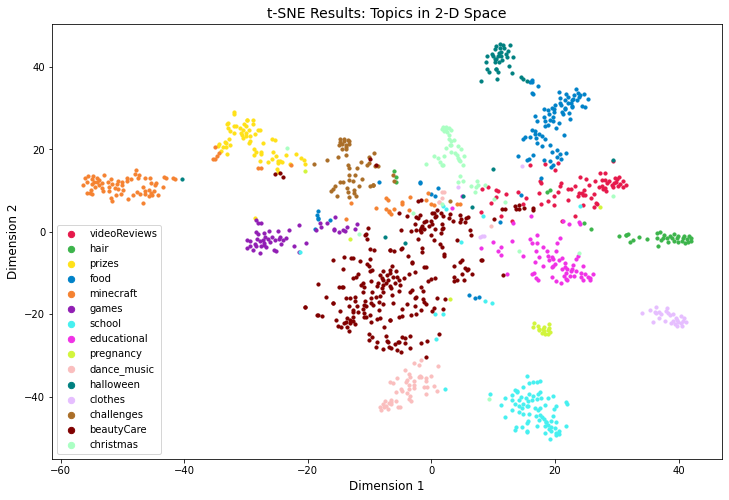

In [47]:
%matplotlib inline
cluster_plot(tsne_data, topic_list)

#### KMeans Visualization

In [48]:
# make sure to have more clusters thanthe number of topics --> can be up to 2**(n-1), where n = # of topics
data = topics_matrix_std   # want to use on the 2-d standard scaled data
pca = PCA(2)
pca_df = pca.fit_transform(data)
pca_df.shape

(1094, 2)

In [49]:
k = 20
km = KMeans(n_clusters=k)
label = km.fit_predict(pca_df)
print(len(label))
label

1094


array([19,  0,  4, ...,  6,  6,  8], dtype=int32)

In [50]:
def kmeans_plot(df, kmeans, label, k):
    '''
    Plot kmeans 
    '''
    # extract all unique labels
    centroids = kmeans.cluster_centers_
    u_labels = np.unique(label)

    plt.figure(figsize=(12, 8))

    # plot the results
    for i in u_labels:
        plt.scatter(df[label == i , 0] , df[label == i , 1] , label = i)
    plt.xlabel('Dimension 1', fontsize=12)
    plt.ylabel('Dimension 2', fontsize=12)
    plt.title(f'K-Means clustering: k = {k}', fontsize=14)
    plt.scatter(centroids[:,0] , centroids[:,1] , s = 50, color = 'k')
    plt.legend()
    plt.show()

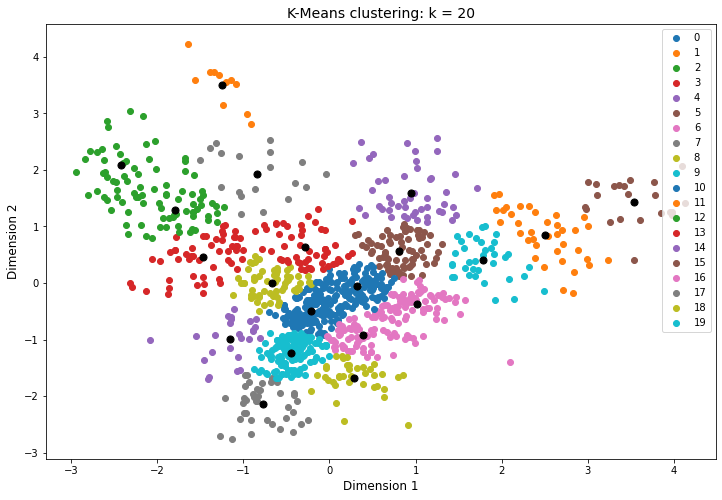

In [51]:
%matplotlib inline
kmeans_plot(pca_df, km, label, k)

### DBSCAN Visualization

In [52]:
def dbscan(X, eps, min_samples):
    '''
    Plot dbscan 
    '''
    ss = StandardScaler()
    X = ss.fit_transform(X)
    db = DBSCAN(eps=eps, min_samples=min_samples)
    db.fit(X)
    y_pred = db.fit_predict(X)
    plt.figure(figsize=(12, 8))
    plt.scatter(X[:,0], X[:,1], c=y_pred, cmap='Paired')
    plt.xlabel('Dimension 1', fontsize=12)
    plt.ylabel('Dimension 2', fontsize=12)
    plt.title("DBSCAN")

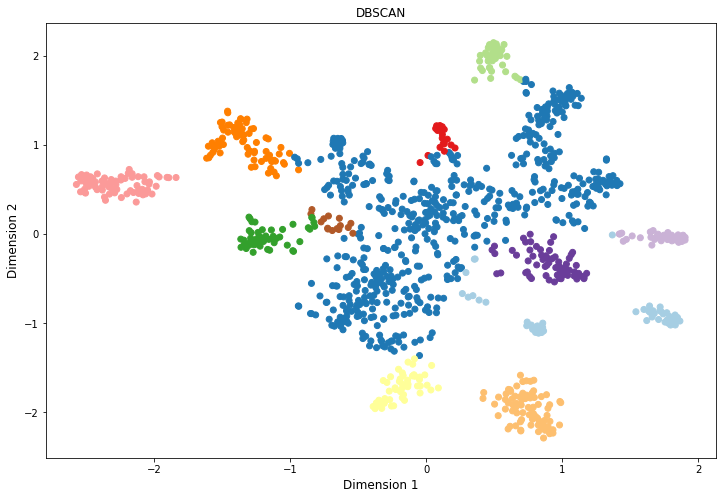

In [53]:
%matplotlib inline
dbscan(topics_mapped_2d, .27, 30)

# EDA of the Topics using MetaData

In [54]:
# assign topics to a the original dataframe
df['topic'] = max_topic_per_post_list
# map topic names to the new dataframe column form topic_dict
df['topic'] = df['topic'].map(topic_dict)

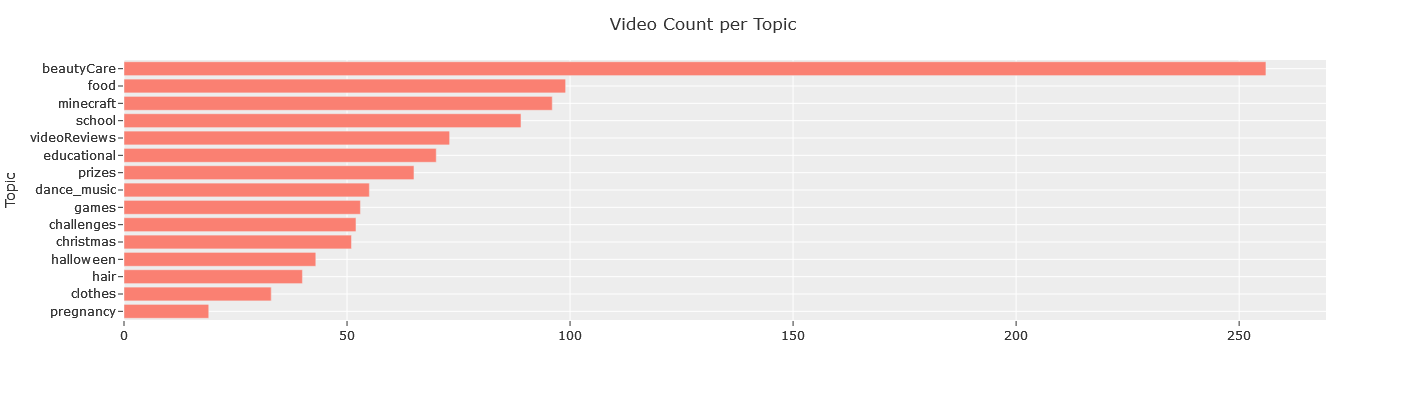

In [66]:
# plt.figure(figsize=(8,6))
# df['topic'].value_counts().plot(kind='barh', color='#d14949')
# plt.gca().invert_yaxis()
# plt.title("Video Count per Topic")
# plt.xlabel('Frequency', fontsize=12)
# plt.ylabel('Topic', fontsize=12)
# plt.grid(color='#948789', linestyle='-.', linewidth=0.1);

# unusable code due to computer issues
fig = px.bar(df['topic'].value_counts(), orientation='h')
fig.update_layout(hovermode='closest', title_text="Video Count per Topic", \
                  barmode='stack', yaxis={'categoryorder':'total ascending'}, width=800, height=400, template='ggplot2')
fig.update_traces(marker_color='#fa8072')
fig.update_layout(showlegend=False)
fig.update_xaxes(title_text="")
fig.update_yaxes(title='Topic')
fig.show()

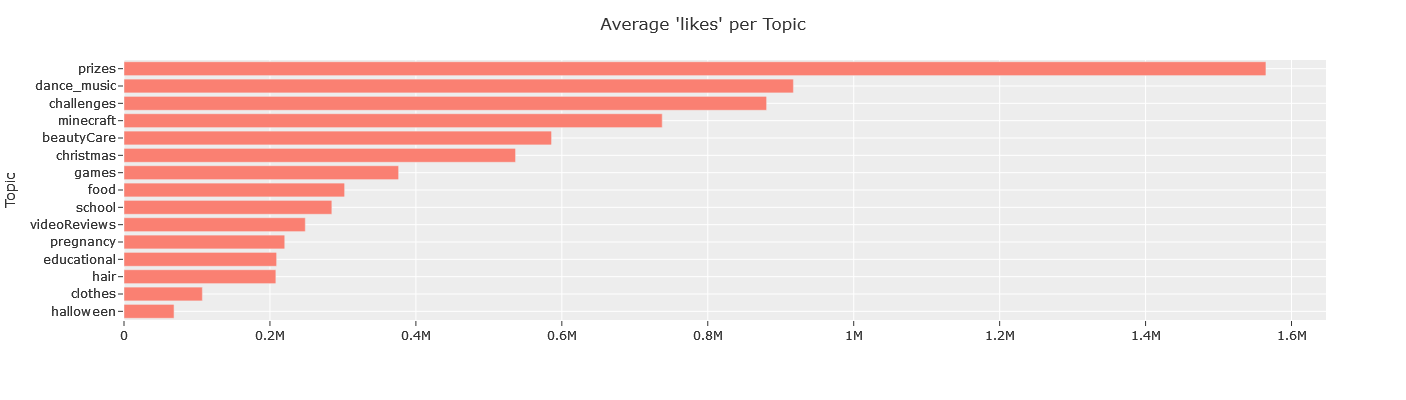

In [68]:
column = 'likes'
# plt.figure(figsize=(8,6))
# df.groupby('topic')[column].mean().sort_values().plot(kind='barh', color='#d14949')
# plt.title(f"Average '{column}' per Topic")
# plt.ylabel('Topic', fontsize=12)
# plt.grid(color='#948789', linestyle='-.', linewidth=0.1);

# unusable code due to computer issues
fig = px.bar(df.groupby('topic')[column].mean().sort_values(), orientation='h')
fig.update_layout(hovermode='closest', title_text=f"Average '{column}' per Topic", \
                  barmode='stack', yaxis={'categoryorder':'total ascending'}, width=800, height=400, template='ggplot2')
fig.update_traces(marker_color='#fa8072')
fig.update_layout(showlegend=False)
fig.update_xaxes(title_text="")
fig.update_yaxes(title='Topic')
fig.show()

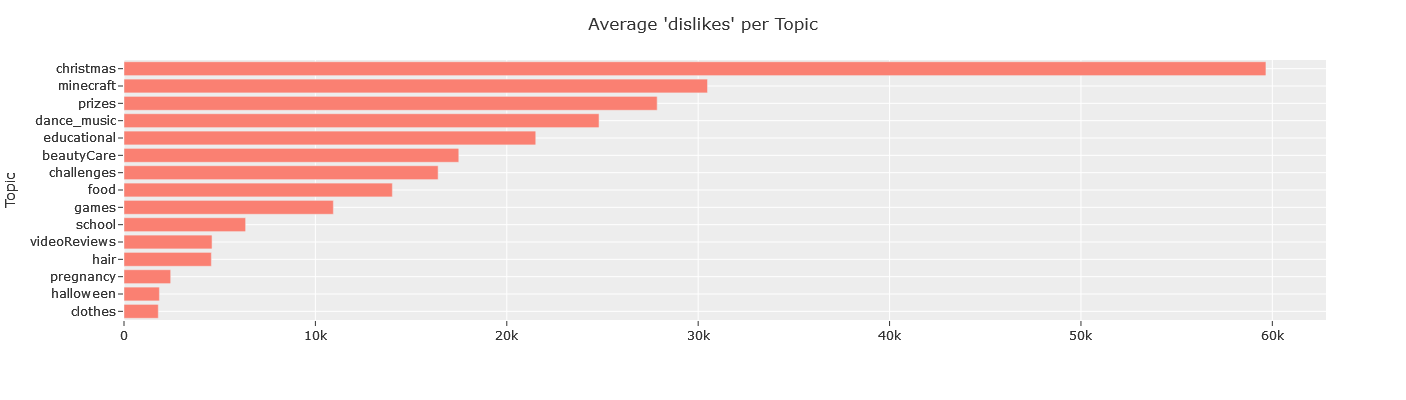

In [69]:
column = 'dislikes'
# plt.figure(figsize=(8,6))
# df.groupby('topic')[column].mean().sort_values().plot(kind='barh', color='#d14949')
# plt.title(f"Average '{column}' per Topic")
# plt.ylabel('Topic', fontsize=12)
# plt.grid(color='#948789', linestyle='-.', linewidth=0.1);

# unusable code due to computer issues
fig = px.bar(df.groupby('topic')[column].mean().sort_values(), orientation='h')
fig.update_layout(hovermode='closest', title_text=f"Average '{column}' per Topic", \
                  barmode='stack', yaxis={'categoryorder':'total ascending'}, width=800, height=400, template='ggplot2')
fig.update_traces(marker_color='#fa8072')
fig.update_layout(showlegend=False)
fig.update_xaxes(title_text="")
fig.update_yaxes(title='Topic')
fig.show()

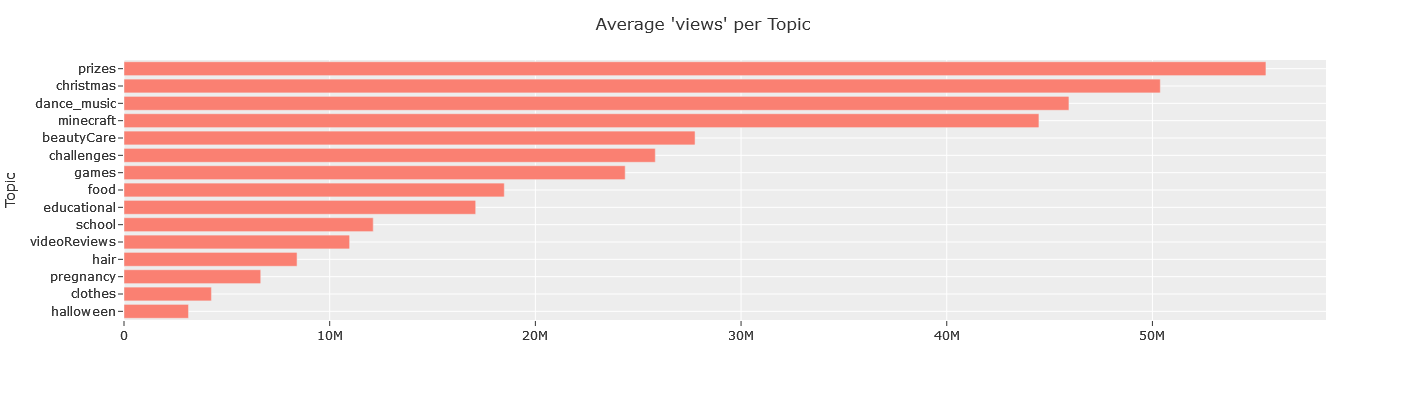

In [70]:
column = 'views'
# plt.figure(figsize=(8,6))
# df.groupby('topic')[column].mean().sort_values().plot(kind='barh', color='#d14949')
# plt.title(f"Average '{column}' per Topic")
# plt.ylabel('Topic', fontsize=12)
# plt.grid(color='#948789', linestyle='-.', linewidth=0.1);

# unusable code due to computer issues
fig = px.bar(df.groupby('topic')[column].mean().sort_values(), orientation='h')
fig.update_layout(hovermode='closest', title_text=f"Average '{column}' per Topic", \
                  barmode='stack', yaxis={'categoryorder':'total ascending'}, width=800, height=400, template='ggplot2')
fig.update_traces(marker_color='#fa8072')
fig.update_layout(showlegend=False)
fig.update_xaxes(title_text="")
fig.update_yaxes(title='Topic')
fig.show()

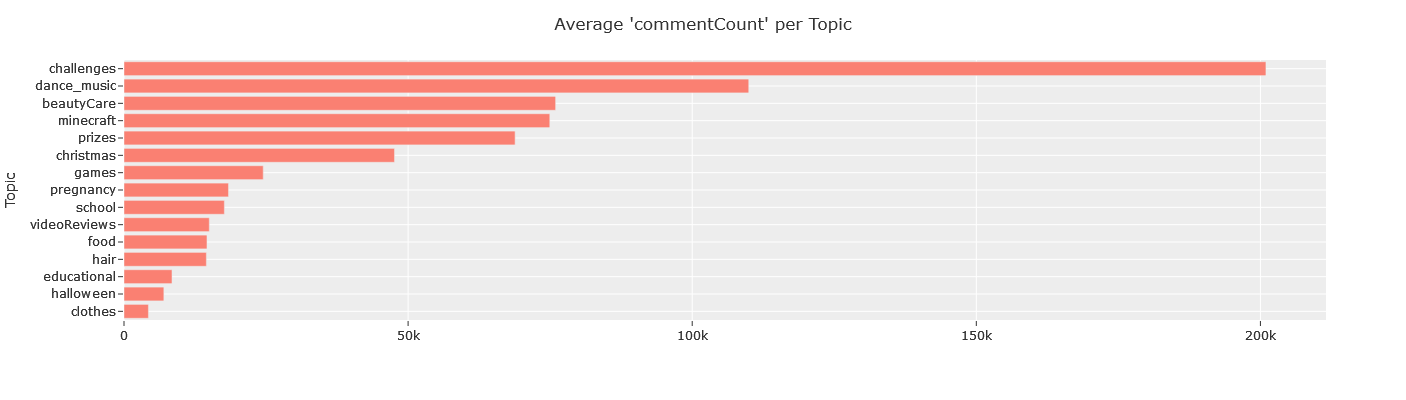

In [71]:
column = 'commentCount'
# plt.figure(figsize=(8,6))
# df.groupby('topic')[column].mean().sort_values().plot(kind='barh', color='#d14949')
# plt.title(f"Average '{column}' per Topic")
# plt.ylabel('Topic', fontsize=12)
# plt.grid(color='#948789', linestyle='-.', linewidth=0.1);

fig = px.bar(df.groupby('topic')[column].mean().sort_values(), orientation='h')
fig.update_layout(hovermode='closest', title_text=f"Average '{column}' per Topic", \
                  barmode='stack', yaxis={'categoryorder':'total ascending'}, width=800, height=400, template='ggplot2')
fig.update_traces(marker_color='#fa8072')
fig.update_layout(showlegend=False)
fig.update_xaxes(title_text="")
fig.update_yaxes(title='Topic')
fig.show()

In [60]:
# create a like ratio to see what topic has the highest ratio
df['likeRatio'] = df['likes'] / df['dislikes']
likeRatio_df = df.replace([np.inf, -np.inf], np.nan, inplace=False)  # remove the inf values created by the column division

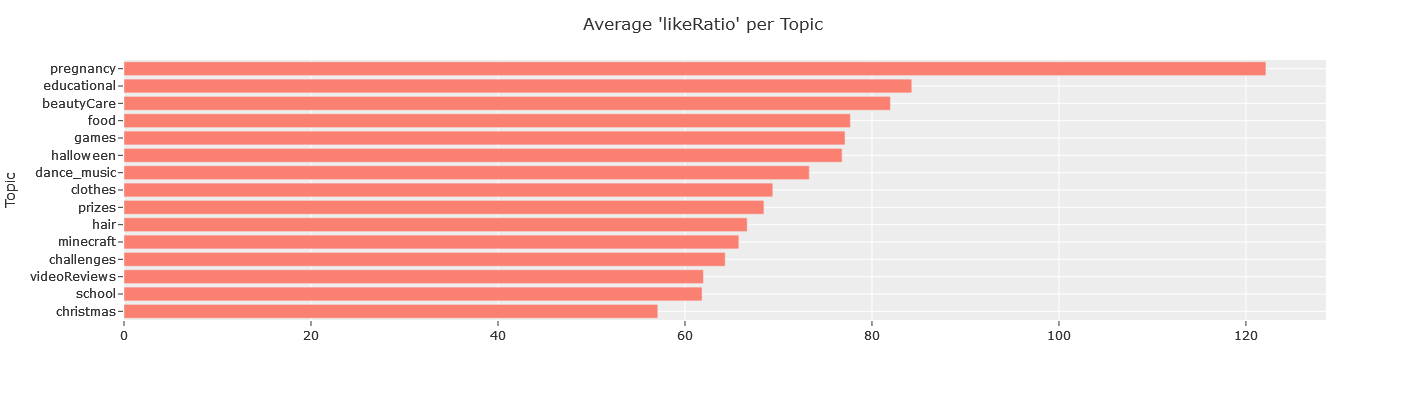

In [72]:
column = 'likeRatio'
# plt.figure(figsize=(8,6))
# likeRatio_df.groupby('topic')[column].mean().sort_values().plot(kind='barh', color='#d14949')
# plt.title(f"Average '{column}' per Topic")
# plt.ylabel('Topic', fontsize=12)
# plt.grid(color='#948789', linestyle='-.', linewidth=0.1);

fig = px.bar(likeRatio_df.groupby('topic')[column].mean().sort_values(), orientation='h')
fig.update_layout(hovermode='closest', title_text=f"Average '{column}' per Topic", \
                  barmode='stack', yaxis={'categoryorder':'total ascending'}, width=800, height=400, template='ggplot2')
fig.update_traces(marker_color='#fa8072')
fig.update_layout(showlegend=False)
fig.update_xaxes(title_text="")
fig.update_yaxes(title='Topic')
fig.show()

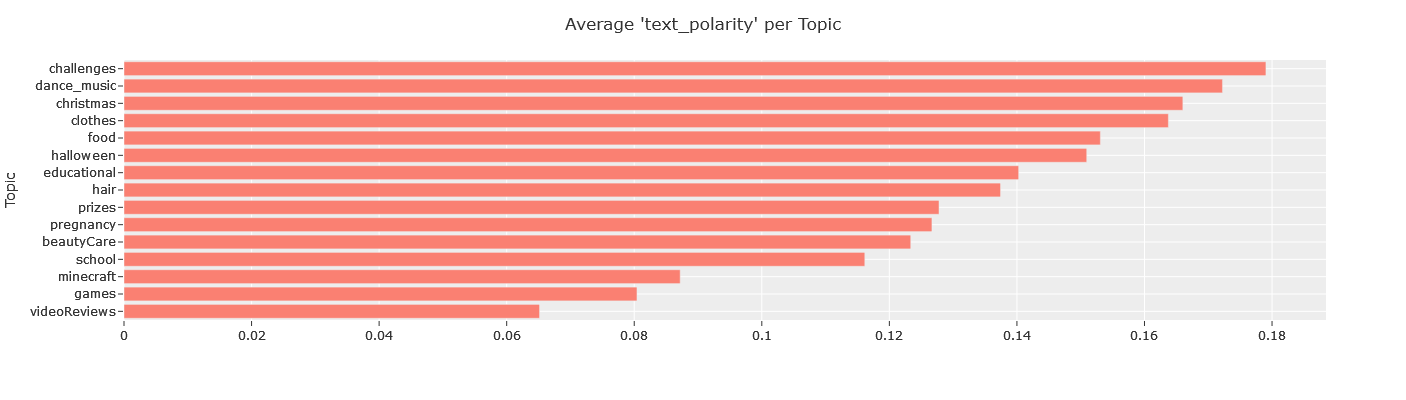

In [73]:
column = 'text_polarity'
# plt.figure(figsize=(8,6))
# df.groupby('topic')[column].mean().sort_values().plot(kind='barh', color='#d14949')
# plt.title(f"Average '{column}' per Topic")
# plt.ylabel('Topic', fontsize=12)
# plt.grid(color='#948789', linestyle='-.', linewidth=0.1);

fig = px.bar(df.groupby('topic')[column].mean().sort_values(), orientation='h')
fig.update_layout(hovermode='closest', title_text=f"Average '{column}' per Topic", \
                  barmode='stack', yaxis={'categoryorder':'total ascending'}, width=800, height=400, template='ggplot2')
fig.update_traces(marker_color='#fa8072')
fig.update_layout(showlegend=False)
fig.update_xaxes(title_text="")
fig.update_yaxes(title='Topic')
fig.show()